### Variational Autoencoders

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

latent_dims = 64
batch_size = 128
lr = 1e-3
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root="./data", train=True, download=False, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [17]:
# First defining the VariationalENCODER class

class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)
        
        self.N = torch.distributions.Normal(0, 1)
        self.kl = 0        
        
    def forward(self, x):
        # aplatit l'image
        x = torch.flatten(x, start_dim=1)
        
        # transforme l'image en représentation itnermédiaire
        x = F.relu(self.linear1(x))
        
        # apprend de la moyenne
        mu = self.linear2(x)
        
        # calcul de l'écart-type, on prend l'exp car self.linear3(x) peut-être négatif
        # l'écart-type représente l'incertitude de l'encodage
        sigma = torch.exp(self.linear3(x))
        
        # on a défini plus haut: self.N = torch.distributions.Normal(0, 1)
        # ça représente une distribution normale standard
        # Avec cette ligne de code, chaque forward produit un z légèrement différent même pour la même image
        z = mu + sigma*self.N.sample(mu.shape)
        
        # Calcul de la KL divergence, c'est quoi la KL DIVERGENCE:
        # C'est une mesure de distance entre deux distributions
        # Elle force l'espace latent à être régularisé autour de N(0, 1)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

# same as for an autoencoder
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

Epoch 1/10
  Total Loss: 69.9457
  Recon Loss: 42.0538
  KL Loss: 27.8919
Epoch 2/10
  Total Loss: 59.4408
  Recon Loss: 28.0048
  KL Loss: 31.4360
Epoch 3/10
  Total Loss: 56.5453
  Recon Loss: 24.1852
  KL Loss: 32.3600
Epoch 4/10
  Total Loss: 55.2100
  Recon Loss: 22.3747
  KL Loss: 32.8353
Epoch 5/10
  Total Loss: 54.4325
  Recon Loss: 21.2661
  KL Loss: 33.1664
Epoch 6/10
  Total Loss: 53.8911
  Recon Loss: 20.4553
  KL Loss: 33.4358
Epoch 7/10
  Total Loss: 53.5172
  Recon Loss: 19.8731
  KL Loss: 33.6440
Epoch 8/10
  Total Loss: 53.2602
  Recon Loss: 19.4455
  KL Loss: 33.8146
Epoch 9/10
  Total Loss: 53.0067
  Recon Loss: 19.0811
  KL Loss: 33.9255
Epoch 10/10
  Total Loss: 52.8263
  Recon Loss: 18.8301
  KL Loss: 33.9961

Model saved to vae_mnist.pth

Generating new images...


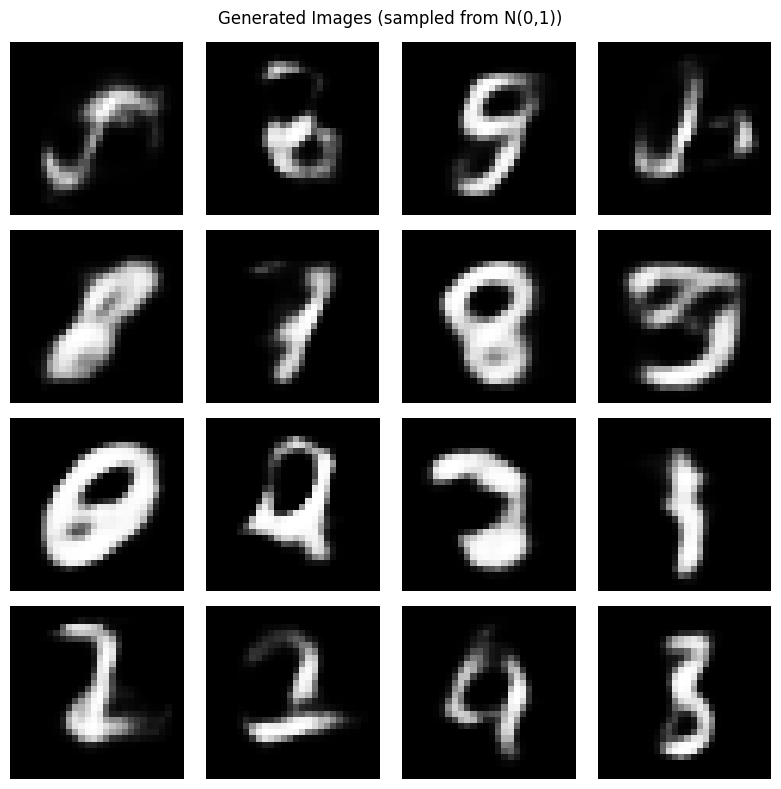


Showing interpolation...


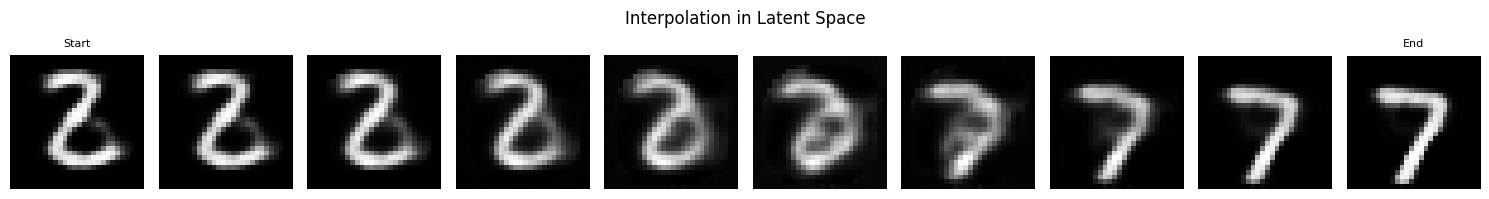

In [19]:
# Defining the train function
def train(autoencoder, data_loader, epochs=10):
    opt = optim.Adam(autoencoder.parameters(), lr=1e-3)
    
    for epoch in range(epochs):
        autoencoder.train()
        total_loss = 0
        total_recon_loss = 0
        total_kl_loss = 0
        
        for batch_idx, (x, y) in enumerate(data_loader):
            x = x.to(device)
            
            # Forward pass
            opt.zero_grad()
            x_hat = autoencoder(x)
            
            # Loss = Reconstruction + KL divergence
            recon_loss = ((x - x_hat)**2).sum()
            kl_loss = autoencoder.encoder.kl
            loss = recon_loss + kl_loss
            
            # Backward pass
            loss.backward()
            opt.step()
            
            # Accumulate losses
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
        
        # Print average losses per epoch
        avg_loss = total_loss / len(data_loader.dataset)
        avg_recon = total_recon_loss / len(data_loader.dataset)
        avg_kl = total_kl_loss / len(data_loader.dataset)
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Total Loss: {avg_loss:.4f}")
        print(f"  Recon Loss: {avg_recon:.4f}")
        print(f"  KL Loss: {avg_kl:.4f}")

# Reconstruction Visualization
def show_reconstruction(model, loader, n=8):
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(loader))
        data = data[:n].to(device)
        recon = model(data).cpu()
        data = data.cpu()
    
    plt.figure(figsize=(12, 3))
    for i in range(n):
        # Original images
        plt.subplot(2, n, i+1)
        plt.imshow(data[i].squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Original', fontsize=10)
        
        # Reconstructed images
        plt.subplot(2, n, n+i+1)
        plt.imshow(recon[i].squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Reconstructed', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Generation Visualization
def show_generation(model, latent_dims, n=16):
    """Generate new images by sampling from N(0,1)"""
    model.eval()
    with torch.no_grad():
        # Sample random latent vectors from N(0,1)
        z = torch.randn(n, latent_dims).to(device)
        # Decode to generate images
        generated = model.decoder(z).cpu()
    
    plt.figure(figsize=(8, 8))
    for i in range(n):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.suptitle('Generated Images (sampled from N(0,1))')
    plt.tight_layout()
    plt.show()

# Interpolation
def show_interpolation(model, loader, n_steps=10):
    """Interpolate between two images in latent space"""
    model.eval()
    with torch.no_grad():
        # Get two random images
        data, _ = next(iter(loader))
        img1 = data[0:1].to(device)
        img2 = data[1:2].to(device)
        
        # Encode to latent space
        z1 = model.encoder(img1)
        z2 = model.encoder(img2)
        
        # Interpolate
        alphas = torch.linspace(0, 1, n_steps)
        interpolations = []
        
        for alpha in alphas:
            z_interp = alpha * z1 + (1 - alpha) * z2
            img_interp = model.decoder(z_interp).cpu()
            interpolations.append(img_interp)
        
        # Visualize
        plt.figure(figsize=(15, 2))
        for i, img in enumerate(interpolations):
            plt.subplot(1, n_steps, i+1)
            plt.imshow(img.squeeze(), cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title('Start', fontsize=8)
            elif i == n_steps - 1:
                plt.title('End', fontsize=8)
        plt.suptitle('Interpolation in Latent Space')
        plt.tight_layout()
        plt.show()

def main():
    # Initialize model
    vae = VariationalAutoencoder(latent_dims).to(device)
    
    # Train the model
    train(vae, train_loader, epochs=epochs)
    
    # Save the model
    torch.save(vae.state_dict(), "vae_mnist.pth")
    print("\nModel saved to vae_mnist.pth")
    
    # Generate new images
    print("\nGenerating new images...")
    show_generation(vae, latent_dims, n=16)
    
    # Show interpolation
    print("\nShowing interpolation...")
    show_interpolation(vae, test_loader, n_steps=10)

main()        

L'espace latent d'un variational autoencoder est structuré et continu, il suit une loit de normale de paramètre mu sigma

La loss du VAE combine deux termes:
total_loss = reconstruction_loss + beta*kl_loss 

reconstruction_loss: mesure à quel point la reconstruction est fidèle
kl_loss: force l'espace latent à suivre N(0,1)